In [438]:
import sys
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy
from qca import QCA
from figures import names
from core1d import rule_hamiltonian
from states import make_state
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from numpy.linalg import multi_dot
from scipy.linalg import expm
from matrix import op_at, dagger
from measures import expectation
from figures import colors
from time import time
%matplotlib inline

In [439]:
import matrix
import qca
import states
import figures
from importlib import reload
reload(matrix)
reload(qca)
reload(states)
reload(figures)

from figures import names, colors
from states import make_state
from measures import get_rhoj, get_expectation
from matrix import ops


# 2-qubit ferromagnetic state at 45 degrees
psi = make_state(2, "ot45")

# verify
rhoj = get_rhoj(psi)
X = get_expectation(rhoj, ops["X"])
Y = get_expectation(rhoj, ops["Y"])
Z = get_expectation(rhoj, ops["Z"])
print(X)
print(Y)
print(Z)
np.arccos(Z/np.sqrt(X*X+Z*Z)) * 180/np.pi

[0.70710678 0.70710678]
[0. 0.]
[0.70710678 0.70710678]


array([45., 45.])

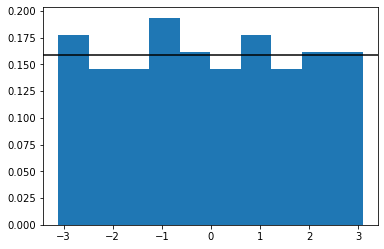

In [440]:
# Haar random matrix
from matrix import haar, isU, ops
U = haar(100) # 100-dimensional array
eigs = np.linalg.eigvals(U)

# haar random matrix is unitary and has eigenvalues exp(i theta) 
# with theta unifromly distributed 
phs = np.angle(eigs)
plt.hist(phs, density="True")
plt.axhline(1/(2*np.pi), c="k")

In [157]:
z = []
N = 10000
A = np.random.normal(0, 1, (N, N))
B = np.random.normal(0, 1, (N, N))
A = A + 1j*B
eigs = np.linalg.eigvals(A)
x = eigs.real
y = eigs.imag
for x0, y0 in zip(x, y):
    d = np.sqrt((x-x0)**2 + (y-y0)**2)
    ns = np.argsort(d)[1:3]
    xnn, xnnn = x[ns]
    ynn, ynnn  = y[ns]
    lnn = xnn + 1j*ynn
    lnnn = xnnn + 1j*ynnn
    lk = x0 + 1j*y0
    z.append((lnn - lk) / (lnnn - lk))
z = np.array(z)

0.24355187694953115 0.7392466759747712


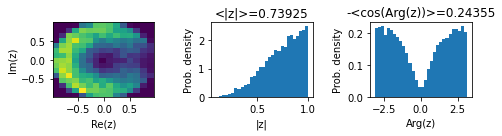

In [164]:
fig, axs = plt.subplots(1,3, figsize=(3.375*2, 2))
phi = np.angle(z)
r = np.abs(z)


axs[0].hist2d(z.real, z.imag, bins=15);
axs[0].set_ylabel("Im(z)")
axs[0].set_xlabel("Re(z)")

axs[1].hist(r, density=True, bins=30);
axs[1].set_ylabel("Prob. density")
axs[1].set_xlabel("|z|")
axs[1].set_title(f"<|z|>={round(np.mean(r), 5)}")

axs[2].hist(phi, density=True, bins=30)
axs[2].set_ylabel("Prob. density")
axs[2].set_xlabel("Arg(z)")
axs[2].set_title(f"-<cos(Arg(z))>={round(-np.mean(np.cos(phi)), 5)}")

plt.tight_layout()
plt.savefig("figures/GinUE-1e4_nn-nnn-ratio.pdf", bbox_inches="tight")
print(-np.mean(np.cos(phi)), np.mean(r))

In [401]:
def proj_k(k, L):
    N = L//2
    Pk = 0
    PI2x = np.eye(len(PI2))
    for x in range(N):
        Pk += np.exp(2*np.pi * 1j * k / N) * matrix_power(PI2, x) / N
        #PI2x = PI2x.dot(PI2)
    return Pk

In [472]:
L=8
from matrix import dec_to_bin, listkron, dagger, isU, isherm
from states import bvecs
from numpy.linalg import matrix_power

def PI2(L):
    PI2 = 0
    for i in range(2**L):
        S = dec_to_bin(i, L)
        Sr = np.roll(S, 2)
        PI2 += np.outer(listkron([bvecs[str(s)] for s in S]),
                       listkron([bvecs[str(s)] for s in Sr]))
    return PI2


def proj_k(k, L):
    N = L//2
    Pk = 0
    pi2 = PI2(L)
    for x in range(N):
        Pk += np.exp(2*np.pi * 1j * k / N) * matrix_power(pi2, x) / N
        #PI2x = PI2x.dot(PI2)
    return Pk

def Q_xform(k, L, J=None):
    Pk = proj_k(k, L)
    Q = []
    for i in range(2**L):
        S = np.array(dec_to_bin(i, L))
        psi_i = listkron([bvecs[str(s)] for s in S])
        psi_i_prime = Pk.dot(psi_i)
        norm = np.conj(psi_i_prime).dot(psi_i_prime)
        psi_i = psi_i_prime / np.sqrt(norm)
        
        if J is None:
            goodJ = True
        
        elif J is not None:
            goodJ = False
            Sz = 1 - 2*S
            N == L//2
            J_prime=0
            J_prime = sum(Sz[(2*x-1)%L]*Sz[(2*x)%L] - Sz[(2*x)%L]*Sz[(2*x+1)%L] for x in range(1, N+1))
            if J_prime == J:
                goodJ = True
        
        if i in (0, 1) and goodJ:
            Q.append(psi_i)
        
        elif i >1 and goodJ:
            if not np.any(np.all(psi_i == Q, axis=1)):
                Q.append(psi_i)
    return np.array(Q).T



In [473]:
1-np.array([0,1])*2

array([ 1, -1])

In [490]:
k = 1
L = 10
R = 1
Q = Q_xform(k, L, J=0)


In [ ]:
from qca import rule_op
bulk = rule_op("H", R, 1)

for kk in range(2):
    for j in range(kk, L, 2):
        left = ["I"]*(j)
        
H = rule_hamiltonian(V="X", R=14, L=L, r=1, BC="0")
Hk = np.linalg.multi_dot([dagger(Q), H, Q])

In [503]:
eigskJ = np.linalg.eigvalsh(Hk)

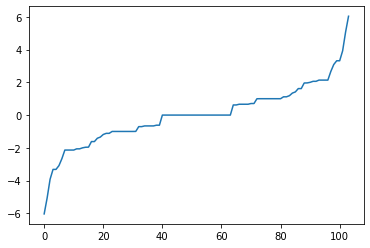

In [504]:
plt.plot(eigskJ)

In [3]:
%%time
der = r"/home/lhillber/documents/research/cellular_automata/qca/data/"
from qca import QCA, QCA_from_file, main_from_params_list

run = False

Rs = [1, 6, 9, 14, 13]
Ls = [6,8,10,12,14,16,18,20,22,24]
ICs = ["c3_f1", "ot45"]

params_template = dict(
              T=100.0,
              L=20,
              dt=1.0,
              r=1,
              V="A",
              BC="0",
              E=0.0,
              N=1,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

params_list = []
Qs = np.zeros((len(ICs), len(Rs), len(Ls)), dtype="object")
for ICi, IC in enumerate(ICs):
    for Ri, R in enumerate(Rs):
        for Li, L in enumerate(Ls):
            params = copy(params_template)
            params["R"] = R
            params["IC"] = IC
            params["L"] = L
            params_list.append(params)
            if not run:
                Q = QCA(params, der=der)
                Qs[ICi, Ri, Li] = Q

print(len(params_list))           
if run:
    main_from_params_list(params_list,
                          tasks=["rhoj", "rhojk", "ebipart", "rho3", "rho4", "rho5"], 
                          der=der, 
                          nprocs=-1,
                          recalc=False)

100
CPU times: user 49.1 ms, sys: 12.3 ms, total: 61.3 ms
Wall time: 64.4 ms


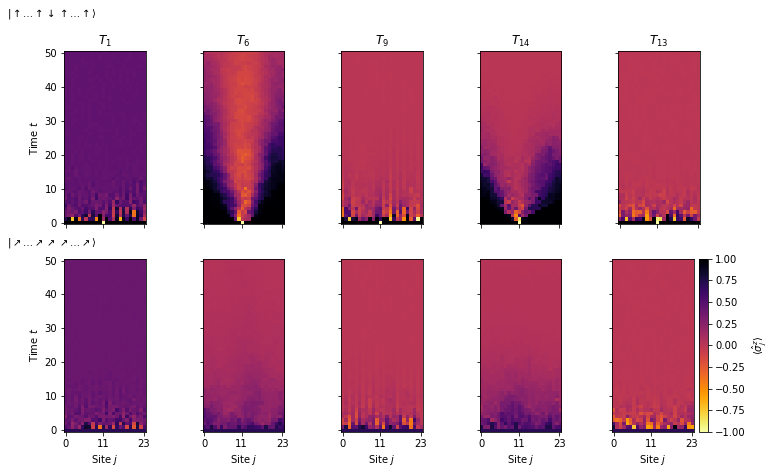

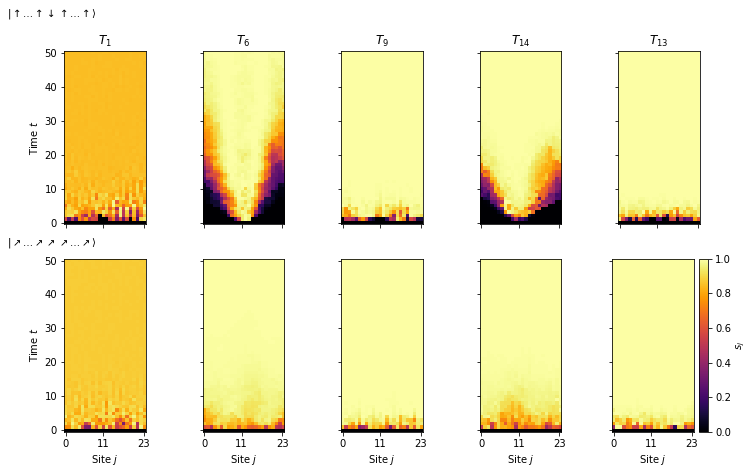

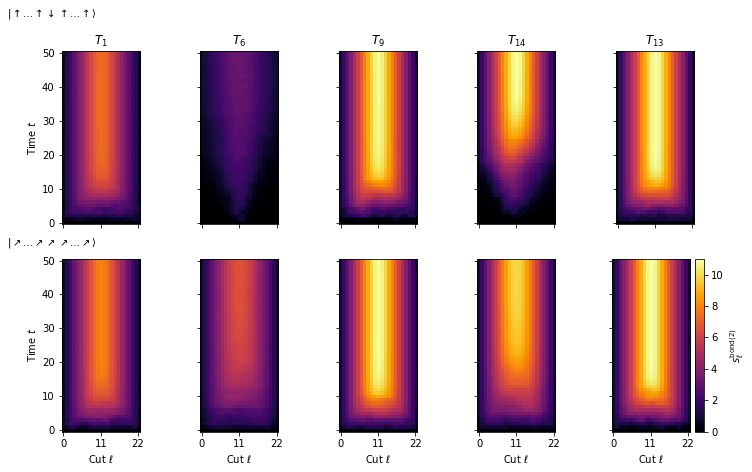

In [31]:
for measi, meas in enumerate(["exp_Z", "s_1", "sbipart_2"]):
    fig, axs = plt.subplots(2, len(Rs), figsize=(12, 7))
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            Q = Qs[ICi, Ri, -1]
            ax = axs[ICi, Ri]
            if meas.split("_")[0] == "s":
                cmap = "inferno"
                vmin=0
                vmax=1
                xticks = [0, 11, 23]
            if meas.split("_")[0] == "sbipart":
                cmap = "inferno"
                vmin=0
                vmax=11
                xticks = [0, 11, 22]
            
            if meas.split("_")[0] == "exp":
                cmap = "inferno_r"
                vmin=-1
                vmax=1
                xticks = [0, 11, 23]
                
            if Ri == len(Rs) -1 and ICi == len(ICs) - 1:
                cbar = True
            else:
                cbar = False
            Q.plot(meas, ax=ax, cbar=cbar, tmax=50, cmap=cmap, vmin=vmin, vmax=vmax)
            if Ri != 0:
                ax.set_ylabel("")
                ax.set_yticklabels([])
            if Ri==0:
                if IC == "c3_f1":
                    ax.text(-0.7, 1.2, r"$| \uparrow \ldots \uparrow \downarrow \uparrow \ldots \uparrow \rangle$", 
                            transform=ax.transAxes, ha="left")
                    
                elif IC == "ot45":
                    ax.text(-0.7, 1.08, r"$|\nearrow \ldots \nearrow \nearrow \nearrow \ldots \nearrow \rangle $", 
                            transform=ax.transAxes, ha="left")
                    
            if ICi != len(ICs)-1:
                ax.set_xlabel("")
                ax.set_xticks(xticks)
                ax.set_xticklabels([])
            else:
                ax.set_xticks(xticks)
            if ICi == 0:
                ax.set_title(r"$T_{%s}$"%R)
    plt.savefig(f"thermo-figures/{meas}_spacetime.pdf")
                

[<matplotlib.patches.Patch object at 0x7f6f13dbcfa0>, <matplotlib.patches.Patch object at 0x7f6f0aeb9a00>, <matplotlib.patches.Patch object at 0x7f6f0b63d100>, <matplotlib.patches.Patch object at 0x7f6f0b1cbd90>, <matplotlib.patches.Patch object at 0x7f6f0b30e910>]


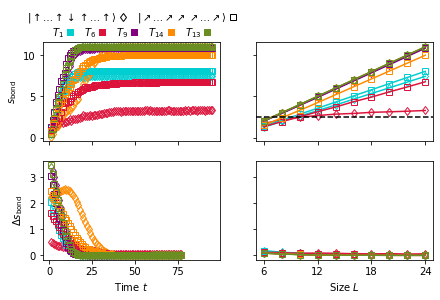

In [66]:
measures = ["sbisect_2", "Dsbisect_2"]
fig, axs = plt.subplots(len(measures), 2, figsize=(7, 4), sharey="row", sharex="col")
for measi, meas in enumerate(measures):
    for ICi, (IC, marker) in enumerate(zip(ICs[:], ["d", "s"][:])):
        for Ri, R in enumerate(Rs):
            ms = []
            for Li, L in enumerate(Ls):
                Q = Qs[ICi, Ri, Li]
                m = Q.get_measure(meas)
                if len(m.shape) == 2:
                         m = m[:, int(L)]
                ms.append(m[3*Q.L:].mean())
            
            ts = Q.ts[:len(m)]
            mask = ts<Q.L*4
            if R == 9 and IC == "c3_f1":
                mask[1] = False
            mask[0] = False
            axs[measi, 0].plot(ts[mask], m[mask], mfc="none", c=colors[R], mec=colors[R], ls="none", marker=marker)
            axs[measi, 1].plot(Ls, ms,  mfc="none", c=colors[R], mec=colors[R], marker=marker)
            
            #axs[measi, 0].set_xscale("log") 
            #axs[measi, 1].set_xscale("log") 
            #axs[measi, 0].set_yscale("log")
            axs[measi, 0].set_ylabel(names[meas])
            axs[len(measures)-1, 0].set_xlabel(names["time"])
            axs[len(measures)-1, 1].set_xlabel(names["size"])
            axs[len(measures)-1, 1].set_xticks([6, 12, 18, 24])
legend_els = [Patch(facecolor=colors[R], edgecolor=None, label=names[R]) for R in Rs]

import matplotlib.lines as mlines

legend_els2 = [
    mlines.Line2D([0], [0], mec='k', mfc="none", marker='d', ls="none",
        label=r"$| \uparrow \ldots \uparrow \downarrow \uparrow \ldots \uparrow \rangle$"),
    mlines.Line2D([0], [0],  mec='k', mfc="none", marker='s', ls="none",
        label=r"$|\nearrow \ldots \nearrow \nearrow \nearrow \ldots \nearrow \rangle $")]
print(legend_els)
axs[0,0].legend(handles=legend_els,
                        loc="center",
                        bbox_to_anchor=[0.5, 1.1],
                        frameon=False,
                        markerfirst=False,
                        ncol=5,
                        columnspacing=1,
                        handletextpad=0.3,
                        handlelength=0.7)
axs[1,0].legend(handles=legend_els2,
                        loc="center",
                        bbox_to_anchor=[0.5, 2.45],
                        frameon=False,
                        markerfirst=False,
                        ncol=5,
                        columnspacing=1,
                        handletextpad=0.3,
                        handlelength=0.7)

axs[0,1].axhline(2.5, c="k", ls="--")

plt.savefig("thermo-figures/random-V_bond-entropy_linear-axes.pdf")

[<matplotlib.patches.Patch object at 0x7f6f13aff790>, <matplotlib.patches.Patch object at 0x7f6f0b0f4460>, <matplotlib.patches.Patch object at 0x7f6f13c9ff70>, <matplotlib.patches.Patch object at 0x7f6f0b4209d0>, <matplotlib.patches.Patch object at 0x7f6f0aea49d0>]


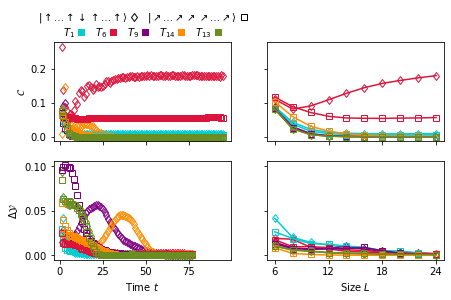

In [61]:
measures = ["C", "DY"]
fig, axs = plt.subplots(len(measures), 2, figsize=(7, 4), sharey="row", sharex="col")
for measi, meas in enumerate(measures):
    for ICi, (IC, marker) in enumerate(zip(ICs[:], ["d", "s"][:])):
        for Ri, R in enumerate(Rs):
            ms = []
            for Li, L in enumerate(Ls):
                Q = Qs[ICi, Ri, Li]
                m = Q.get_measure(meas)
                if len(m.shape) == 2:
                         m = m[:, int(L)]
                ms.append(m[3*Q.L:].mean())
            
            ts = Q.ts[:len(m)]
            mask = ts<Q.L*4
            if R == 9 and IC == "c3_f1":
                mask[1] = False
            mask[0] = False
            axs[measi, 0].plot(ts[mask], m[mask], mfc="none", c=colors[R], mec=colors[R], ls="none", marker=marker)
            axs[measi, 1].plot(Ls, ms,  mfc="none", c=colors[R], mec=colors[R], marker=marker)
            
            #axs[measi, 0].set_xscale("log") 
            #axs[measi, 1].set_xscale("log") 
            #axs[measi, 0].set_yscale("log")
            axs[measi, 0].set_ylabel(names[meas])
            axs[len(measures)-1, 0].set_xlabel(names["time"])
            axs[len(measures)-1, 1].set_xlabel(names["size"])
            axs[len(measures)-1, 1].set_xticks([6, 12, 18, 24])
legend_els = [Patch(facecolor=colors[R], edgecolor=None, label=names[R]) for R in Rs]

import matplotlib.lines as mlines

legend_els2 = [
    mlines.Line2D([0], [0], mec='k', mfc="none", marker='d', ls="none",
        label=r"$| \uparrow \ldots \uparrow \downarrow \uparrow \ldots \uparrow \rangle$"),
    mlines.Line2D([0], [0],  mec='k', mfc="none", marker='s', ls="none",
        label=r"$|\nearrow \ldots \nearrow \nearrow \nearrow \ldots \nearrow \rangle $")]
print(legend_els)
axs[0,0].legend(handles=legend_els,
                        loc="center",
                        bbox_to_anchor=[0.5, 1.1],
                        frameon=False,
                        markerfirst=False,
                        ncol=5,
                        columnspacing=1,
                        handletextpad=0.3,
                        handlelength=0.7)
axs[1,0].legend(handles=legend_els2,
                        loc="center",
                        bbox_to_anchor=[0.5, 2.45],
                        frameon=False,
                        markerfirst=False,
                        ncol=5,
                        columnspacing=1,
                        handletextpad=0.3,
                        handlelength=0.7)

plt.savefig("thermo-figures/random-V_clustering-disparity-fluctuations_linear-axes.pdf")

In [11]:
colors

{6: 'crimson',
 1: 'darkturquoise',
 14: 'darkorange',
 13: 'olivedrab',
 4: 'darkgoldenrod',
 26: 'olivedrab',
 15: 'k',
 8: 'purple',
 'R': 'k',
 9: 'purple'}

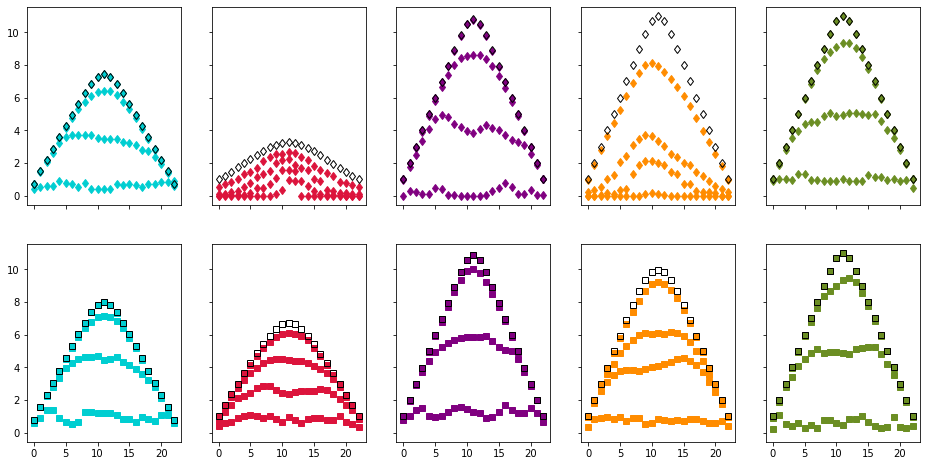

In [37]:
fig, axs = plt.subplots(len(ICs),len(Rs), figsize=(16, 8), sharey=True, sharex=True)
for ICi, (IC, marker) in enumerate(zip(ICs, ["d", "s"])):
    for Ri, R in enumerate(Rs):
        ax = axs[ICi, Ri]
        for L, ls in zip([24], ["-"]):
            for t in [1, L/4, L/2, L, -1]:
                Li = Ls.index(L)
                Q = Qs[ICi, Ri, Li]
                if t == -1:
                    m = np.mean(Q.get_measure("sbipart_2")[50:], axis=0)
                    ax.plot(m, mec="k", mfc="none", marker=marker, ls="none", lw=1)


                else:
                    m = np.mean(Q.get_measure("sbipart_2")[int(t):int(t)+1], axis=0)
                    ax.plot(m, color=colors[R], marker=marker, ls="none", lw=1)

                #ax.set_xscale("log")
                #ax.set_yscale("log")

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

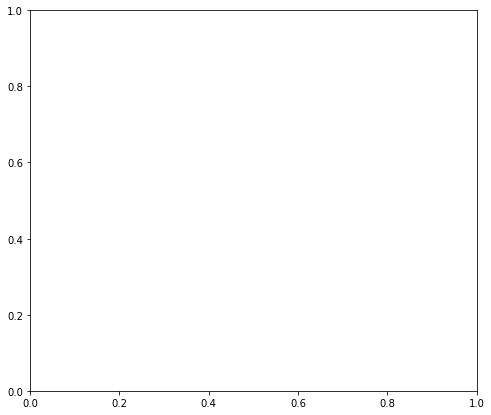

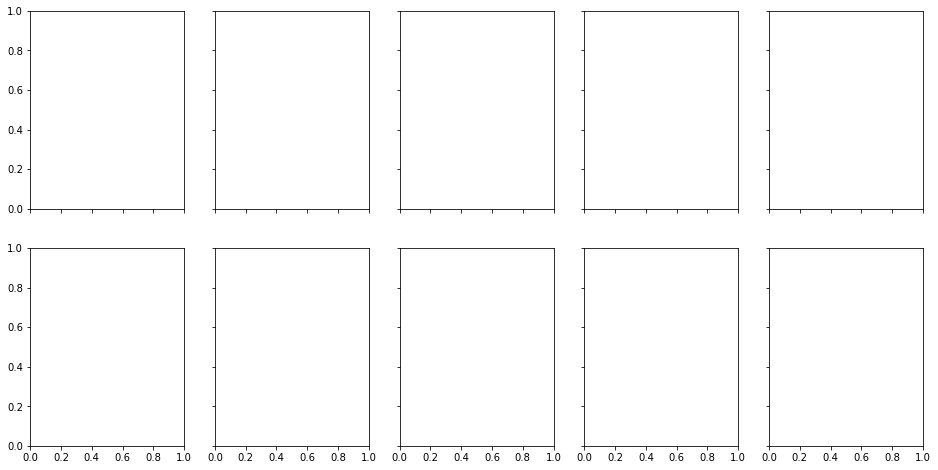

In [13]:
fig, axs = plt.subplots(1,1, figsize=(8, 7))
measures = ["sbisect_2", "exp_Z"]
fig, axs = plt.subplots(len(ICs),len(Rs), figsize=(16, 8), sharey=True, sharex=True)
for ICi, (IC, marker) in enumerate(zip(ICs, ["d", "s"])):
    ax = axs
    for Ri, R in enumerate(Rs):
        ms = []
        for Li, L in enumerate(Ls):
            Q = Qs[ICi, Ri, Li]
            m = Q.get_measure("sbisect_2")[50:].mean()
            ms.append(m)
        ax.plot(np.array(Ls)*(1+Ri/100
                             ), ms, color=colors[R], marker=marker, ls="-", lw=1)
        
        ax.set_xscale("log")
        ax.set_yscale("log")

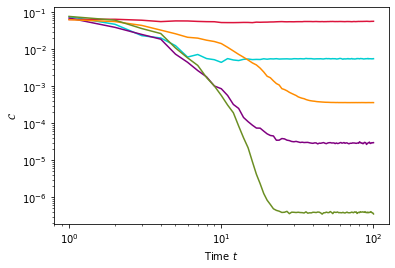

In [61]:
fig, ax = plt.subplots(1,1)
for Ri, R in enumerate(Rs[:]):
    Q = Qs[-1, Ri, -1]
    Q.plot("C", tmin=1, ax=ax, color=colors[R])
ax.set_yscale("log")
ax.set_xscale("log")

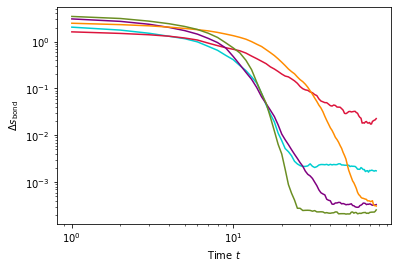

In [96]:
fig, ax = plt.subplots(1,1)
for Ri, R in enumerate(Rs[:]):
    Q = Qs[-1, Ri, -1]
    Q.plot("Dsbisect_2", tmin=1, ax=ax, color=colors[R], Dmode="std")
    ax.set_yscale("log")
    ax.set_xscale("log")

In [97]:
%%time
der = r"/home/lhillber/documents/research/cellular_automata/qca/data/"
from qca import QCA, QCA_from_file, main_from_params_list

run = False

Rs = [1, 6, 9, 14, 13]
Ls = [6,8,10,12,14,16,18] #20, 22, 24
ICs = ["ot45"]

params_template = dict(
              T=100.0,
              L=20,
              dt=1.0,
              r=1,
              V="A",
              BC="0",
              E=0.0,
              N=100, #100
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

params_list = []
Qs = np.zeros((len(ICs), len(Rs), len(Ls)), dtype="object")
for ICi, IC in enumerate(ICs):
    for Ri, R in enumerate(Rs):
        for Li, L in enumerate(Ls):
            params = copy(params_template)
            params["R"] = R
            params["IC"] = IC
            params["L"] = L
            params_list.append(params)
            if not run:
                Q = QCA(params, der=der)
                Qs[ICi, Ri, Li] = Q
                
print(len(params_list))           
if run:
    main_from_params_list(params_list,
                          tasks=["rhoj", "rhojk", "ebipart", "rho3", "rho4", "rho5"], 
                          der=der, 
                          nprocs=16,
                          recalc=False)

35
CPU times: user 77 ms, sys: 0 ns, total: 77 ms
Wall time: 74.1 ms


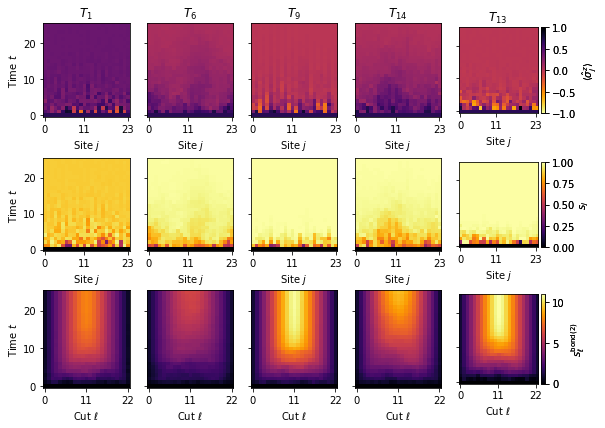

In [7]:
measures = ["exp_Z", "s_1", "sbipart_2"]
fig, axs = plt.subplots(len(measures), len(Rs), figsize=(9, 7))
for measi, meas in enumerate(measures):
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            if Ri == len(Rs) - 1:
                cbar = True
            else:
                cbar = False
            Q = Qs[ICi, Ri, -1]
            ax = axs[measi, Ri]
            Q.plot(meas, ax=ax, tmax=25, cbar=cbar, cmap=cmap, vmin=vmin, vmax=vmax) 
            
            if meas.split("_")[0] == "s":
                cmap = "inferno"
                vmin=0
                vmax=1
                xticks = [0, (Q.L-1)//2, Q.L-1]
            elif meas.split("_")[0] == "exp":
                cmap = "inferno_r"
                vmin=-1
                vmax=1
                xticks = [0, (Q.L-1)//2, Q.L-1]
            elif meas.split("_")[0] == "sbipart":
                cmap = "inferno"
                vmin=0
                vmax=(Q.L-1)//2
                xticks = [0, (Q.L-2)//2, Q.L-2]
            if Ri != 0:
                ax.set_ylabel("")
                ax.set_yticklabels([])
                
            ax.set_xticks(xticks)
                
            if measi == 0:
                ax.set_title(r"$T_{%s}$"%R)
plt.savefig("figures/1pt_and_Page.pdf", bbox_inches="tight")

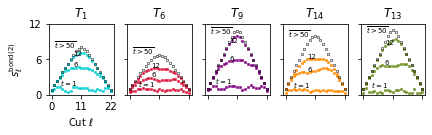

In [23]:
measures = ["sbipart_2"]
fig, axs = plt.subplots(len(measures), len(Rs), figsize=(3.375*2, 1.3), sharey="row")
for measi, meas in enumerate(measures):
    for IC in ["ot45"]:
        ICi = ICs.index(IC)
        for Ri, R in enumerate(Rs):
            Q = Qs[ICi, Ri, Li]
            ax = axs [Ri]
            for t in [1, Q.L//4, Q.L//2, -1]:
                if t == -1:
                    m = np.mean(Q.get_measure(meas)[50:], axis=0)
                    ax.plot(m, mec="k", mfc="none", marker="s", ls="none", ms=2.5, lw=1, mew=0.5)
                    ax.text(9.3, m[9], r"$\overline{t>50}$", fontsize=7, va="bottom", ha="right")


                else:
                    m = np.mean(Q.get_measure(meas)[int(t):int(t)+1], axis=0)
                    ax.plot(m, color=colors[R], marker="s", ls="none", ms=2.5, lw=1, mew=0.5)
                    if t==1:
                        ax.text(9.3, m[8], r"$t=%s$"%t, fontsize=7, va="bottom", ha="right")   
                    else:
                         ax.text(8, m[8], t, fontsize=7, va="bottom")
            ax.set_yticks([0, Q.L//4, Q.L//2])
            ax.set_xticks([0, (Q.L-2)//2, Q.L-2])
            ax.set_xticklabels([])
            if Ri == 0:
                ax.set_ylabel(names[meas])
                ax.set_xlabel(names["cut"])
                ax.set_xticklabels([0, (Q.L-2)//2, Q.L-2])
            ax.set_title(names[R])
            ax.set_ylim(top=Q.L//2)
plt.savefig("thermo-figures/random-V_Page-curve_1trials.pdf", bbox_inches="tight")

[<matplotlib.patches.Patch object at 0x7f84eba8e1f0>, <matplotlib.patches.Patch object at 0x7f8551ff5160>, <matplotlib.patches.Patch object at 0x7f8551ec8700>, <matplotlib.patches.Patch object at 0x7f83e9c3e760>, <matplotlib.patches.Patch object at 0x7f83e9c3ea90>]


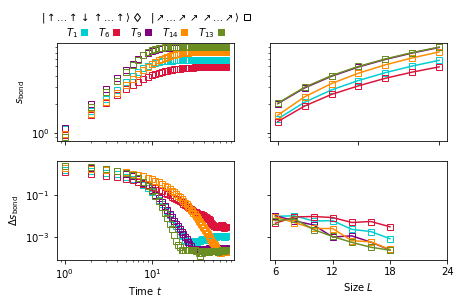

In [186]:
measures = ["sbisect_2", "Dsbisect_2"]
fig, axs = plt.subplots(len(measures), 2, figsize=(7, 4), sharey="row", sharex="col")
for measi, meas in enumerate(measures):
    for ICi, (IC, marker) in enumerate(zip(ICs[:], ["s"][:])):
        for Ri, R in enumerate(Rs):
            ms = []
            for Li, L in enumerate(Ls):
                Q = Qs[ICi, Ri, Li]
                m = Q.get_measure(meas)
                if len(m.shape) == 2:
                         m = m[:, int(L)]
                ms.append(m[-1])
            
            ts = Q.ts[:len(m)]
            mask = ts<Q.L*4
            if R == 9 and IC == "c3_f1":
                print("enetyer")
                mask[1] = False
            mask[0] = False
            axs[measi, 0].plot(ts[mask], m[mask], mfc="none", c=colors[R], mec=colors[R], ls="none", marker=marker)
            axs[measi, 1].plot(Ls, ms,  mfc="none", c=colors[R], mec=colors[R], marker=marker)
            
            axs[measi, 0].set_xscale("log") 
            #axs[measi, 1].set_xscale("log") 
            axs[measi, 0].set_yscale("log")
            axs[measi, 0].set_ylabel(names[meas])
            axs[len(measures)-1, 0].set_xlabel(names["time"])
            axs[len(measures)-1, 1].set_xlabel(names["size"])
            axs[len(measures)-1, 1].set_xticks([6, 12, 18, 24])
legend_els = [Patch(facecolor=colors[R], edgecolor=None, label=names[R]) for R in Rs]

import matplotlib.lines as mlines

legend_els2 = [
    mlines.Line2D([0], [0], mec='k', mfc="none", marker='d', ls="none",
        label=r"$| \uparrow \ldots \uparrow \downarrow \uparrow \ldots \uparrow \rangle$"),
    mlines.Line2D([0], [0],  mec='k', mfc="none", marker='s', ls="none",
        label=r"$|\nearrow \ldots \nearrow \nearrow \nearrow \ldots \nearrow \rangle $")]
print(legend_els)
axs[0,0].legend(handles=legend_els,
                        loc="center",
                        bbox_to_anchor=[0.5, 1.1],
                        frameon=False,
                        markerfirst=False,
                        ncol=5,
                        columnspacing=1,
                        handletextpad=0.3,
                        handlelength=0.7)
"""
axs[1,0].legend(handles=legend_els2,
                        loc="center",
                        bbox_to_anchor=[0.5, 2.45],
                        frameon=False,
                        markerfirst=False,
                        ncol=5,
                        columnspacing=1,
                        handletextpad=0.3,
                        handlelength=0.7)
"""
plt.savefig("thermo-figures/random-V_bond-entropy.pdf")

In [51]:
from scipy.optimize import curve_fit
def exp_func(x, c, A, B):
    return A*np.exp(-x / c) + B

def pow_func(x, c, A, B):
    return A*x**(-c) + B

def fit(x, y, exp_p0=(-1.0, 0.1, 0.0), pow_p0=(-1.0, 0.1, 0.0)):
    exp_p0 = (1.0, 1, y[-1])
    try:
        exp_popt, exp_pcov = curve_fit(exp_func, x, y, p0=exp_p0,
                                      bounds=((-np.inf,0,-1), (np.inf, np.inf, 1)))
    except:
        exp_popt = [-1, -1, -1]
        exp_pcov = [-1, -1, -1]
    def expf(x):
        return exp_func(x, *exp_popt)
    exp_rms = np.sqrt(np.sum((y - expf(x))**2))
    
    pow_p0 = (0.0, 1, y[-1])
    try:
        pow_popt, pow_pcov = curve_fit(pow_func, x, y, p0=pow_p0, bounds=((-np.inf,0,-1), (np.inf, np.inf, 1)))
    except: 
        pow_popt = [-1, -1, -1]
        pow_pcov = [-1, -1, -1]
    def powf(x):
        return pow_func(x, *pow_popt)
    
    pow_rms = np.sqrt(np.sum((y - powf(x))**2)) 
    fs = [expf, powf]
    popts = [exp_popt, pow_popt]
    pcovs  = [exp_pcov, pow_pcov]
    rms = [exp_rms, pow_rms]
    
    if np.abs(rms[1] - rms[0]) > 1e-3:
        ind = np.argmin(rms)
    else:
        ind = 1
    
    
    return ind, fs, popts, pcovs, rms

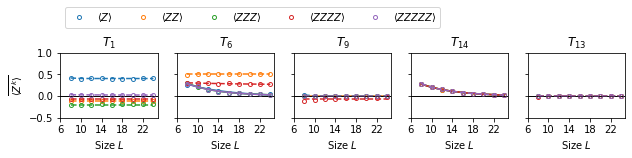

In [52]:
op = "Z"
lss = ["-", "--"]
fitfs = ["exp", "pow"]
measures = [f"expn_{op*i}" for i in range(1, 6)]
fig, axs = plt.subplots(1, len(Rs), figsize=(3.375*3, 6/5))
for Ri, R in enumerate(Rs[:]):
    ax = axs[Ri]
    for measi, meas in enumerate(measures):
        color = f"C{measi}"
        for IC in ["ot45"]:
            ICi = ICs.index(IC)
            ms = []
            for L in Ls[1:]:
                Li = Ls.index(L)
                Q = Qs[ICi, Ri, Li]
                if meas == "s":
                    cmap = "inferno"
                    vmin=None
                    vmax=1
                else:
                    cmap = "inferno_r"
                    vmin=None
                    vmax=None
                m = Q.get_measure(meas)
                ms.append(m[30:].mean())
            x = np.array(Ls[1:], dtype=float)
            y = np.array(ms)
            ax.plot(x, y, marker="o", mec=color, mfc="none", ms=4, ls="none", label=r"$\langle %s \rangle$"%meas.split("_")[1])
            ind, fs, popts, pcovs, rms = fit(x, y)
            f = fs[ind](x)
            if np.all(f[-1]<1e-2):
                #ax.plot(x, y, c=color, ls="-")
                pass
            #if f[-1] > -1:
            ax.plot(x, f, color=color, ls=lss[ind])
            ax.set_yticks([-0.5, 0, 0.5, 1.0])
            if Ri != 0:
                ax.set_ylabel("")
                ax.set_yticklabels([])
            else:
                ax.set_ylabel(r"$\overline{\langle Z^k \rangle}$")


            ax.set_xticks(Ls[::2])
            ax.set_xlabel("Size $L$")
            if measi == 0:
                ax.set_title(r"$T_{%s}$"%R)
            if Ri == 0 :
                ax.legend(loc="lower left", 
                          bbox_to_anchor=(0,1.3),
                          ncol=len(Ls))
            ax.minorticks_off()
            ax.axhline(0, c="k", lw=0.5)
            #ax.set_yscale("log")



1 pow 1 [1.48986248e+01 3.63579370e+11 4.04118021e-01]
1 pow 2 [11.93081965  0.91871835 -0.10541721]
1 pow 3 [ 1.76790882e+01  9.53887147e-03 -1.92833526e-01]
1 pow 4 [ 1.27189373e+01  9.70746288e-03 -7.16076269e-02]
1 pow 5 [1.03188585 0.0831547  0.02409046]
6 exp 1 [8.14410403 0.7619843  0.03678559]
6 pow 2 [18.46927278  0.23114312  0.50124809]
6 exp 3 [5.52702561 1.18565685 0.0248718 ]
6 pow 4 [0.02419104 1.37232409 0.26851797]
6 exp 5 [6.32196711 0.97526299 0.0253938 ]
9 pow 1 [1.50471983e+01 1.00780488e+12 1.77989736e-04]
9 exp 2 [1.86705628e-01 3.01714604e-01 7.70924366e-05]
9 pow 3 [ 1.05950252e+01  4.82475324e-04 -6.24385877e-05]
9 pow 4 [ 9.58080630e+00  5.05548807e-04 -3.27364851e-02]
9 pow 5 [ 1.72529105e+01  1.87505640e-02 -3.62398766e-05]
14 exp 1 [6.46237986 0.94717753 0.02431697]
14 exp 2 [6.43446384 0.96803042 0.02423449]
14 exp 3 [6.41619232 0.96209205 0.0230209 ]
14 exp 4 [6.82122085 0.89635281 0.02313449]
14 pow 5 [1.23515381 4.69261155 0.02313742]
13 pow 1 [ 1.11712

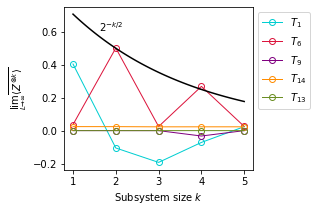

In [60]:
op = "Z"
lss = ["-", "--"]
fitfs = ["exp", "pow"]
measures = [f"expn_{op*i}" for i in range(1, 6)]
fig, ax = plt.subplots(1, 1, figsize=(3.375, 3))
for Ri, R in enumerate(Rs[:]):
    popts = []
    for measi, meas in enumerate(measures):
        color = f"C{measi}"
        for IC in ["ot45"]:
            ICi = ICs.index(IC)
            ms = []
            for L in Ls[1:]:
                Li = Ls.index(L)
                Q = Qs[ICi, Ri, Li]
                if meas == "s":
                    cmap = "inferno"
                    vmin=None
                    vmax=1
                else:
                    cmap = "inferno_r"
                    vmin=None
                    vmax=None
                m = Q.get_measure(meas)
                ms.append(m[30:].mean())
            x = np.array(Ls[1:], dtype=float)
            y = np.array(ms)
            ind, fs, poptsf, pcovs, rms = fit(x, y)
            poptsf[ind][-1] = y[-1]
            popts.append(poptsf[ind])
            #popts.append(ms[-1])
            print(R, fitfs[ind], measi+1, popts[-1])
    popts = np.array(popts)
    ax.plot(np.arange(1, len(measures)+1), popts[:, -1], label=names[R], lw=1, marker="o", color=colors[R], mfc="none", mec=colors[R])
    ax.set_ylabel(r"$\lim_{L\to \infty} \overline {\langle Z^{\otimes k} \rangle}$")
    ax.set_xlabel("Subsystem size $k$")
    #ax.set_yscale("log")
    
ns = np.linspace(1,5, 100)
ax.plot(ns, [1/2**(n/2) for n in ns], c="k")
ax.text(1.6, 0.6, r"$2^{-k/2}$")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("infinite-size_pauliZ_thermalization_1trial.pdf", bbox_inches="tight")

            